<a href="https://www.kaggle.com/code/oscarm524/ps-s3-ep19-eda-modeling-submission?scriptVersionId=137275410" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Notebook Versions](#1)

[2. Loading Libraries](#2)

[3. Reading Data Files](#3)

[4. Data Exploration](#4)

[5. Baseline Modeling 1.0](#5)

[6. Baseline Modeling 2.0](#6)


<a id="1"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Notebook Versions</h1>

1. Version 1 (07/10/2023)
    * EDA 
    * Baseline modeling 1.0
    
    
    
2. Version 2 (07/12/2023)
    * EDA updated
    * Baseline modeling 1.0 updated
    


3. Version 3 (07/13/2023)
    * Baseline modeling 1.0 updated
    


4. Version 4 (07/17/2023)
    * Baseline modeling 2.0 added


    
5. Version 5 (07/19/2023)
    * Baseline modeling 2.0 updated
    

<a id="2"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Loading Libraries</h1>    

In [1]:
pip install sklego

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm.notebook import tqdm

import holidays

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold, GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklego.linear_model import LADRegression

<a id="3"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1> 

In [3]:
train = pd.read_csv('../input/playground-series-s3e19/train.csv')
train['date'] = pd.to_datetime(train['date'])

## Removing covid dates
train = train.loc[~((train['date'] >= '2020-03-01') & (train['date'] < '2020-06-01'))]

test = pd.read_csv('../input/playground-series-s3e19/test.csv')
test['date'] = pd.to_datetime(test['date'])

submission = pd.read_csv('../input/playground-series-s3e19/sample_submission.csv')
submission.columns = ['id', 'num_sold']

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)
print('The dimension of the submission dataset is:', submission.shape)

The dimension of the train dataset is: (130050, 6)
The dimension of the test dataset is: (27375, 5)
The dimension of the submission dataset is: (27375, 2)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130050 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        130050 non-null  int64         
 1   date      130050 non-null  datetime64[ns]
 2   country   130050 non-null  object        
 3   store     130050 non-null  object        
 4   product   130050 non-null  object        
 5   num_sold  130050 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 6.9+ MB


In [5]:
train.head()

id       date    country         store  \
0   0 2017-01-01  Argentina  Kaggle Learn   
1   1 2017-01-01  Argentina  Kaggle Learn   
2   2 2017-01-01  Argentina  Kaggle Learn   
3   3 2017-01-01  Argentina  Kaggle Learn   
4   4 2017-01-01  Argentina  Kaggle Learn   

                                          product  num_sold  
0               Using LLMs to Improve Your Coding        63  
1                   Using LLMs to Train More LLMs        66  
2  Using LLMs to Win Friends and Influence People         9  
3      Using LLMs to Win More Kaggle Competitions        59  
4                      Using LLMs to Write Better        49

In [6]:
test.head()

id       date    country         store  \
0  136950 2022-01-01  Argentina  Kaggle Learn   
1  136951 2022-01-01  Argentina  Kaggle Learn   
2  136952 2022-01-01  Argentina  Kaggle Learn   
3  136953 2022-01-01  Argentina  Kaggle Learn   
4  136954 2022-01-01  Argentina  Kaggle Learn   

                                          product  
0               Using LLMs to Improve Your Coding  
1                   Using LLMs to Train More LLMs  
2  Using LLMs to Win Friends and Influence People  
3      Using LLMs to Win More Kaggle Competitions  
4                      Using LLMs to Write Better

<a id="4"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1>

First, we start by visualizing `num_sold` by `product` and `country`.

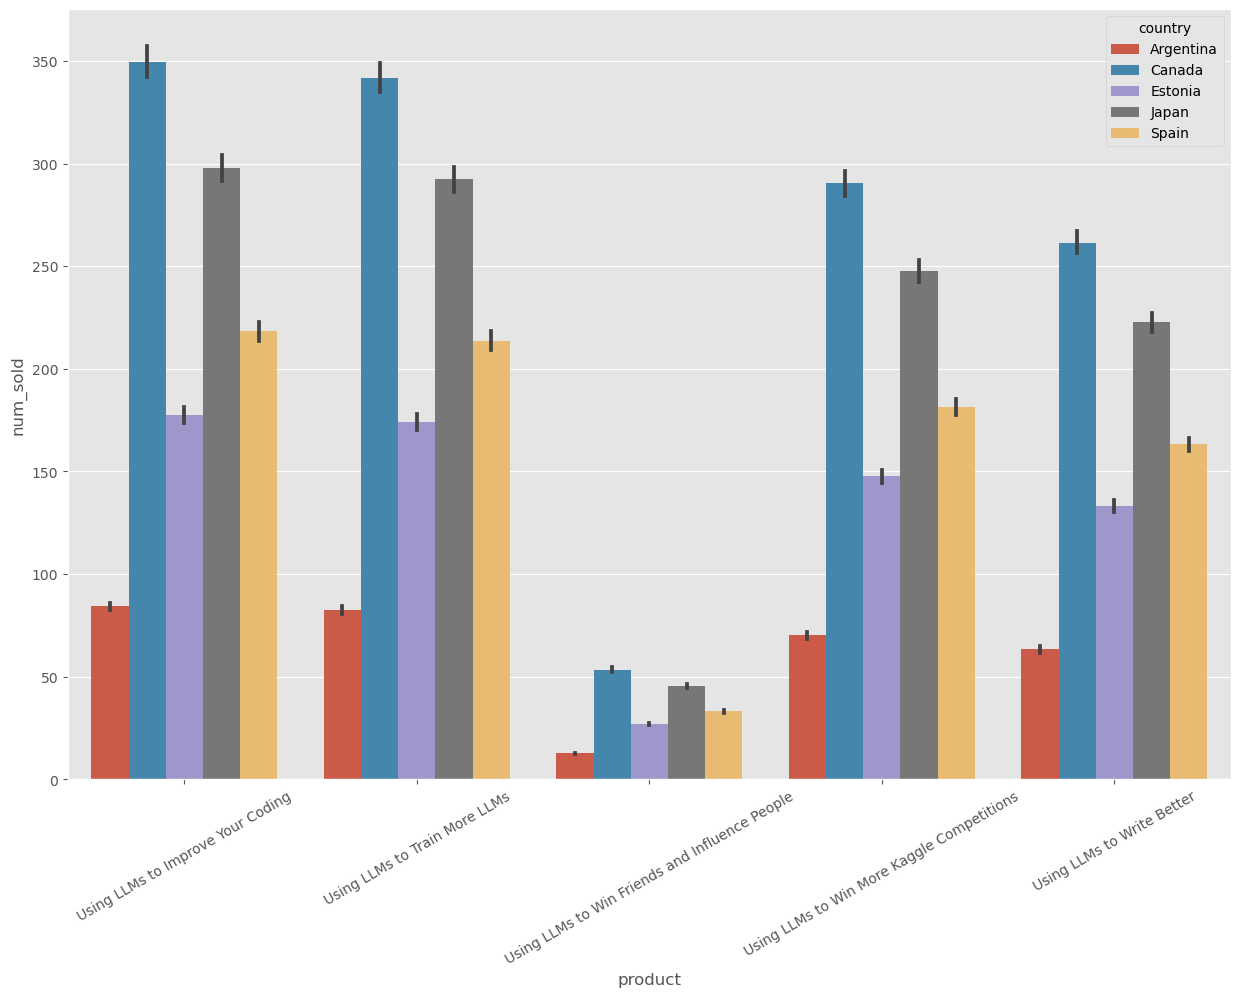

In [7]:
plt.figure(figsize = (15, 10))

ax = sns.barplot(data = train, x = 'product', y = 'num_sold', hue = 'country')
plt.xticks(rotation = 30);

From the above, we see the following:

- All products are sold in all the countries.
- `Using LLMs to Improve Your Coding` is the most sold product across the countries.
- `Using LLMS to Win Friends and Influence People` is the least sold product across the countries.
- `Canada` is the country with the highest sales.
- `Argentina` is the country with the least sales.

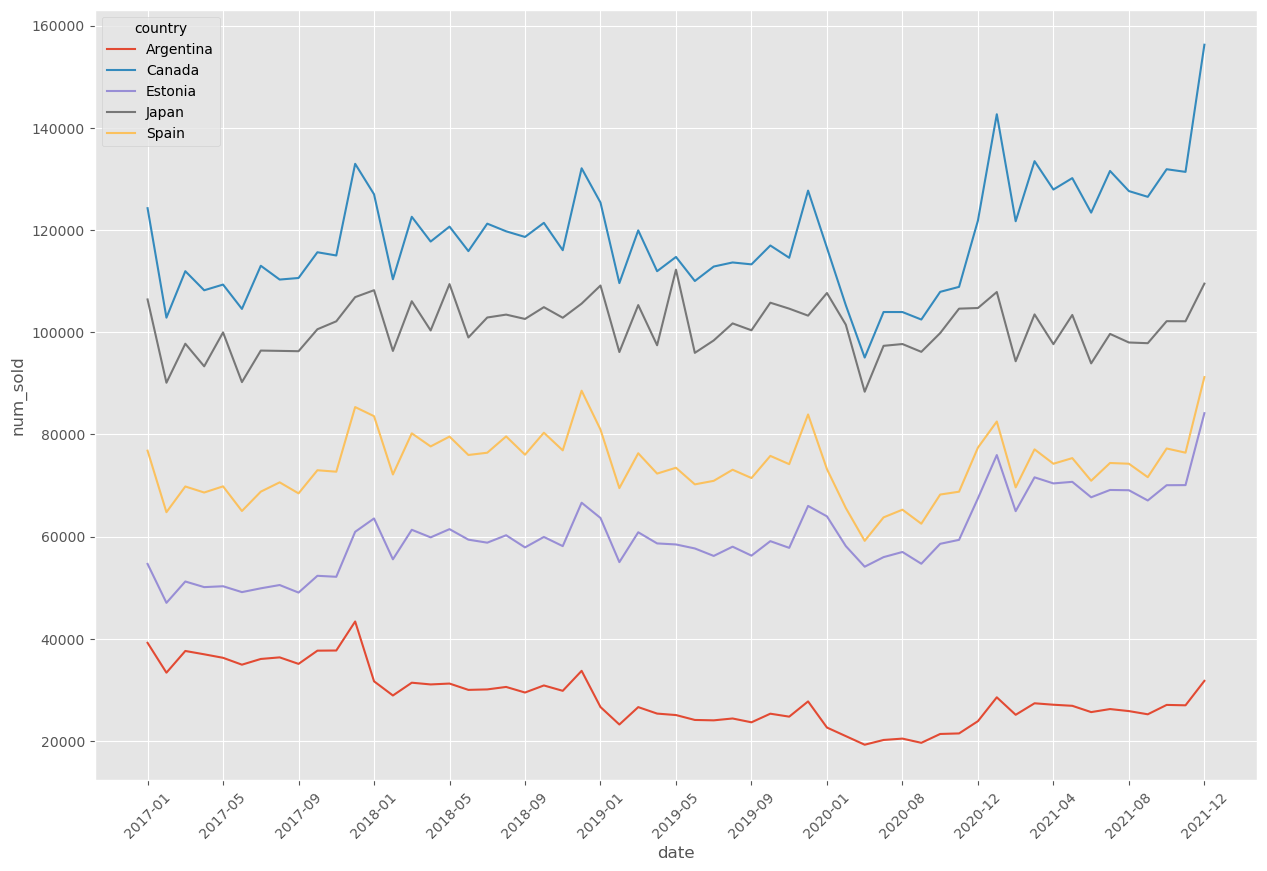

In [8]:
plt.figure(figsize = (15, 10))

ax = sns.lineplot(data = train.groupby([train.date.dt.strftime('%Y-%m'), train.country])['num_sold'].sum().reset_index(),
                  x = 'date',
                  y = 'num_sold',
                  hue ='country')

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20))
plt.xticks(rotation = 45);

From the above, we see that all the countries experience a significant decrease in sales in March and April of 2020 due to the pandemic.

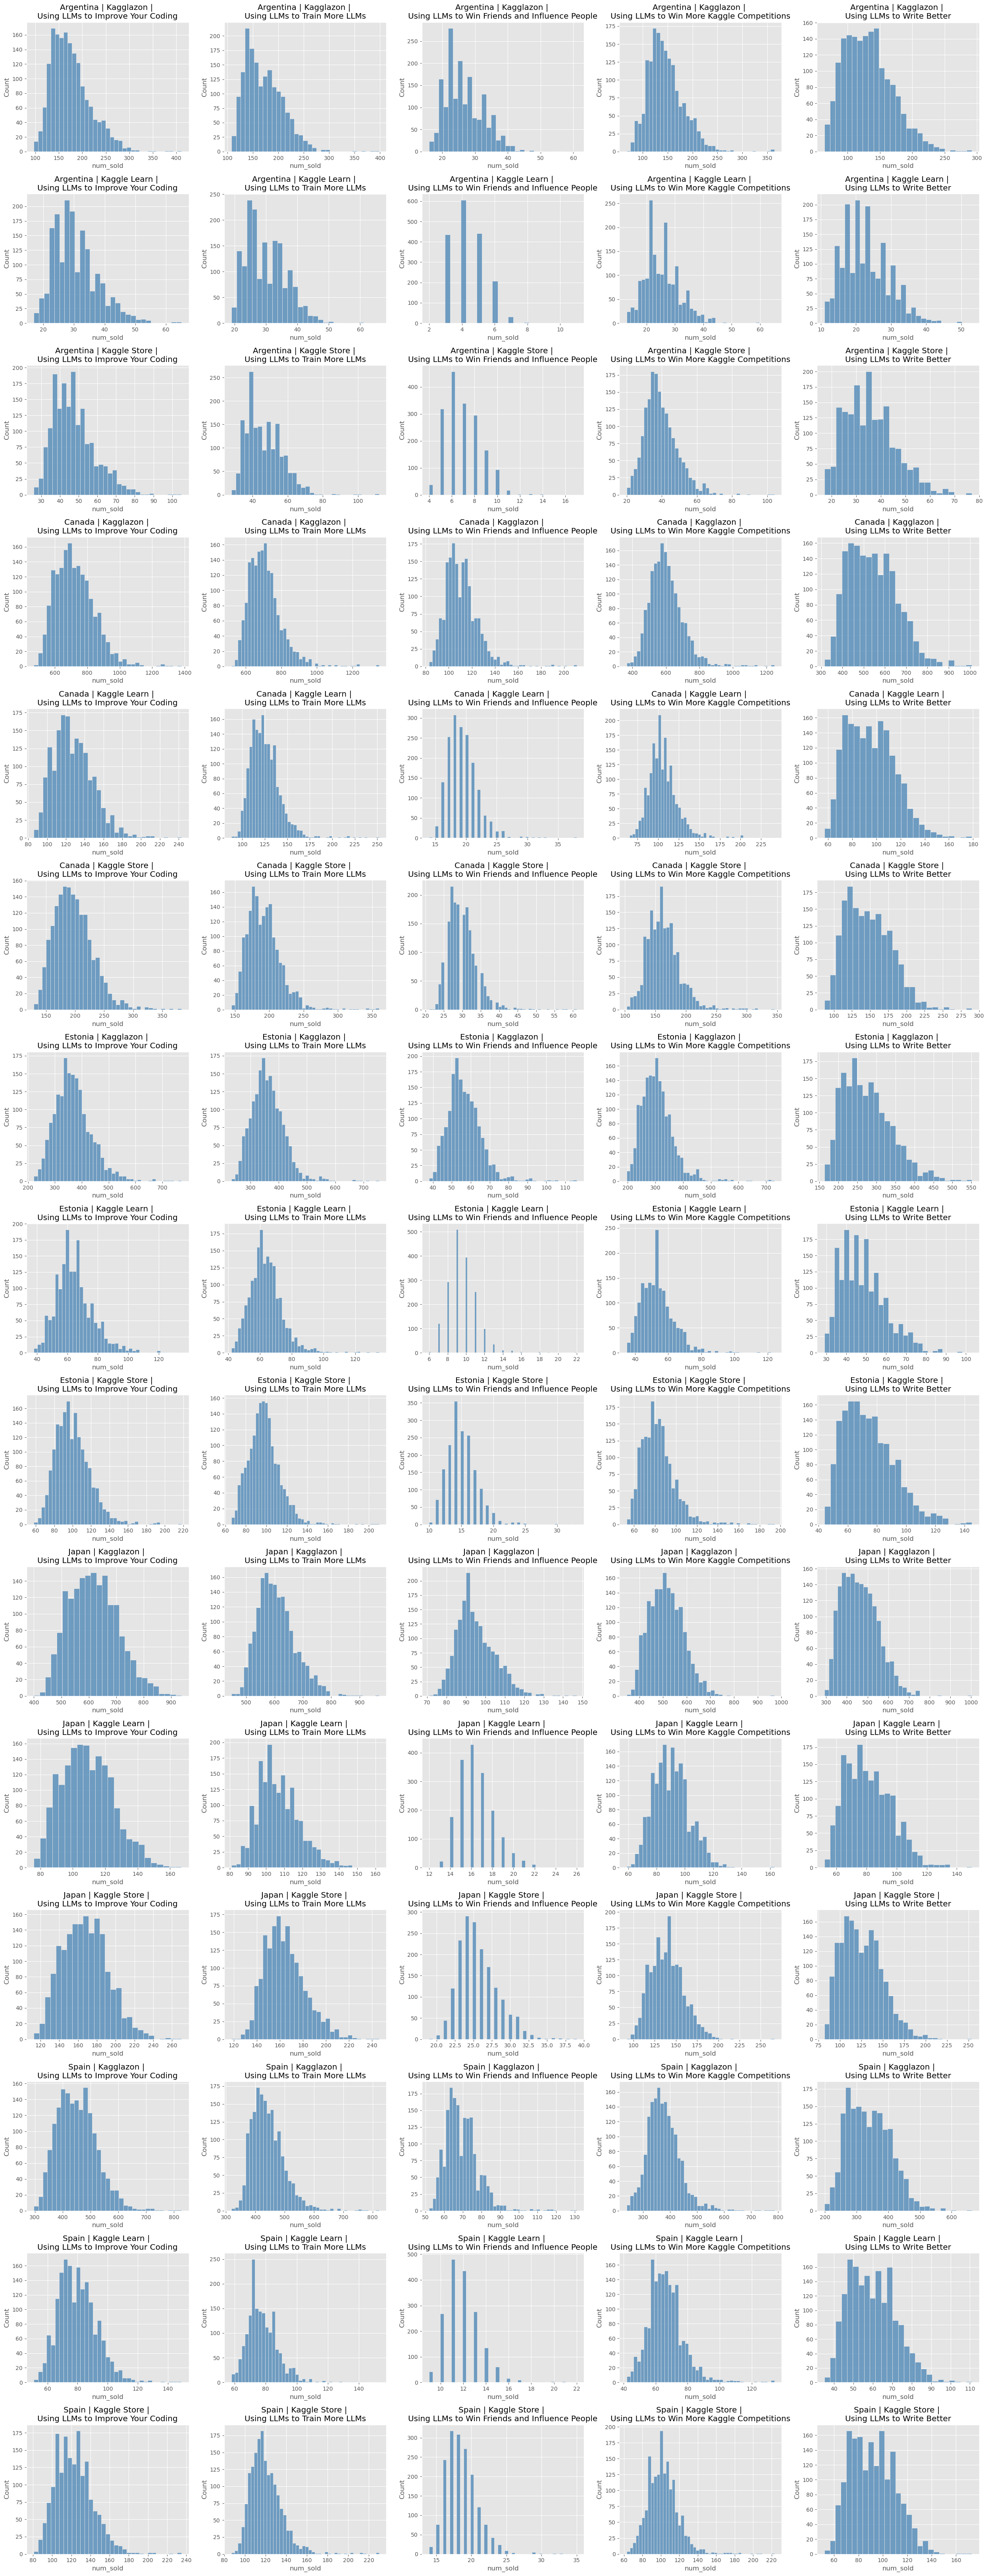

In [9]:
fig, ax = plt.subplots(15, 5, figsize = (25, 65))
ax = ax.flatten()

for i, (combination, df) in enumerate(train.groupby(['country', 'store', 'product'])):
    sns.histplot(df.num_sold, ax = ax[i], color = 'steelblue')
    ax[i].set_title(combination[0] + ' | ' + combination[1] +  ' | ' + '\n' + combination[2])

plt.tight_layout()

From the above we see that most of the distributions are right-skewed.

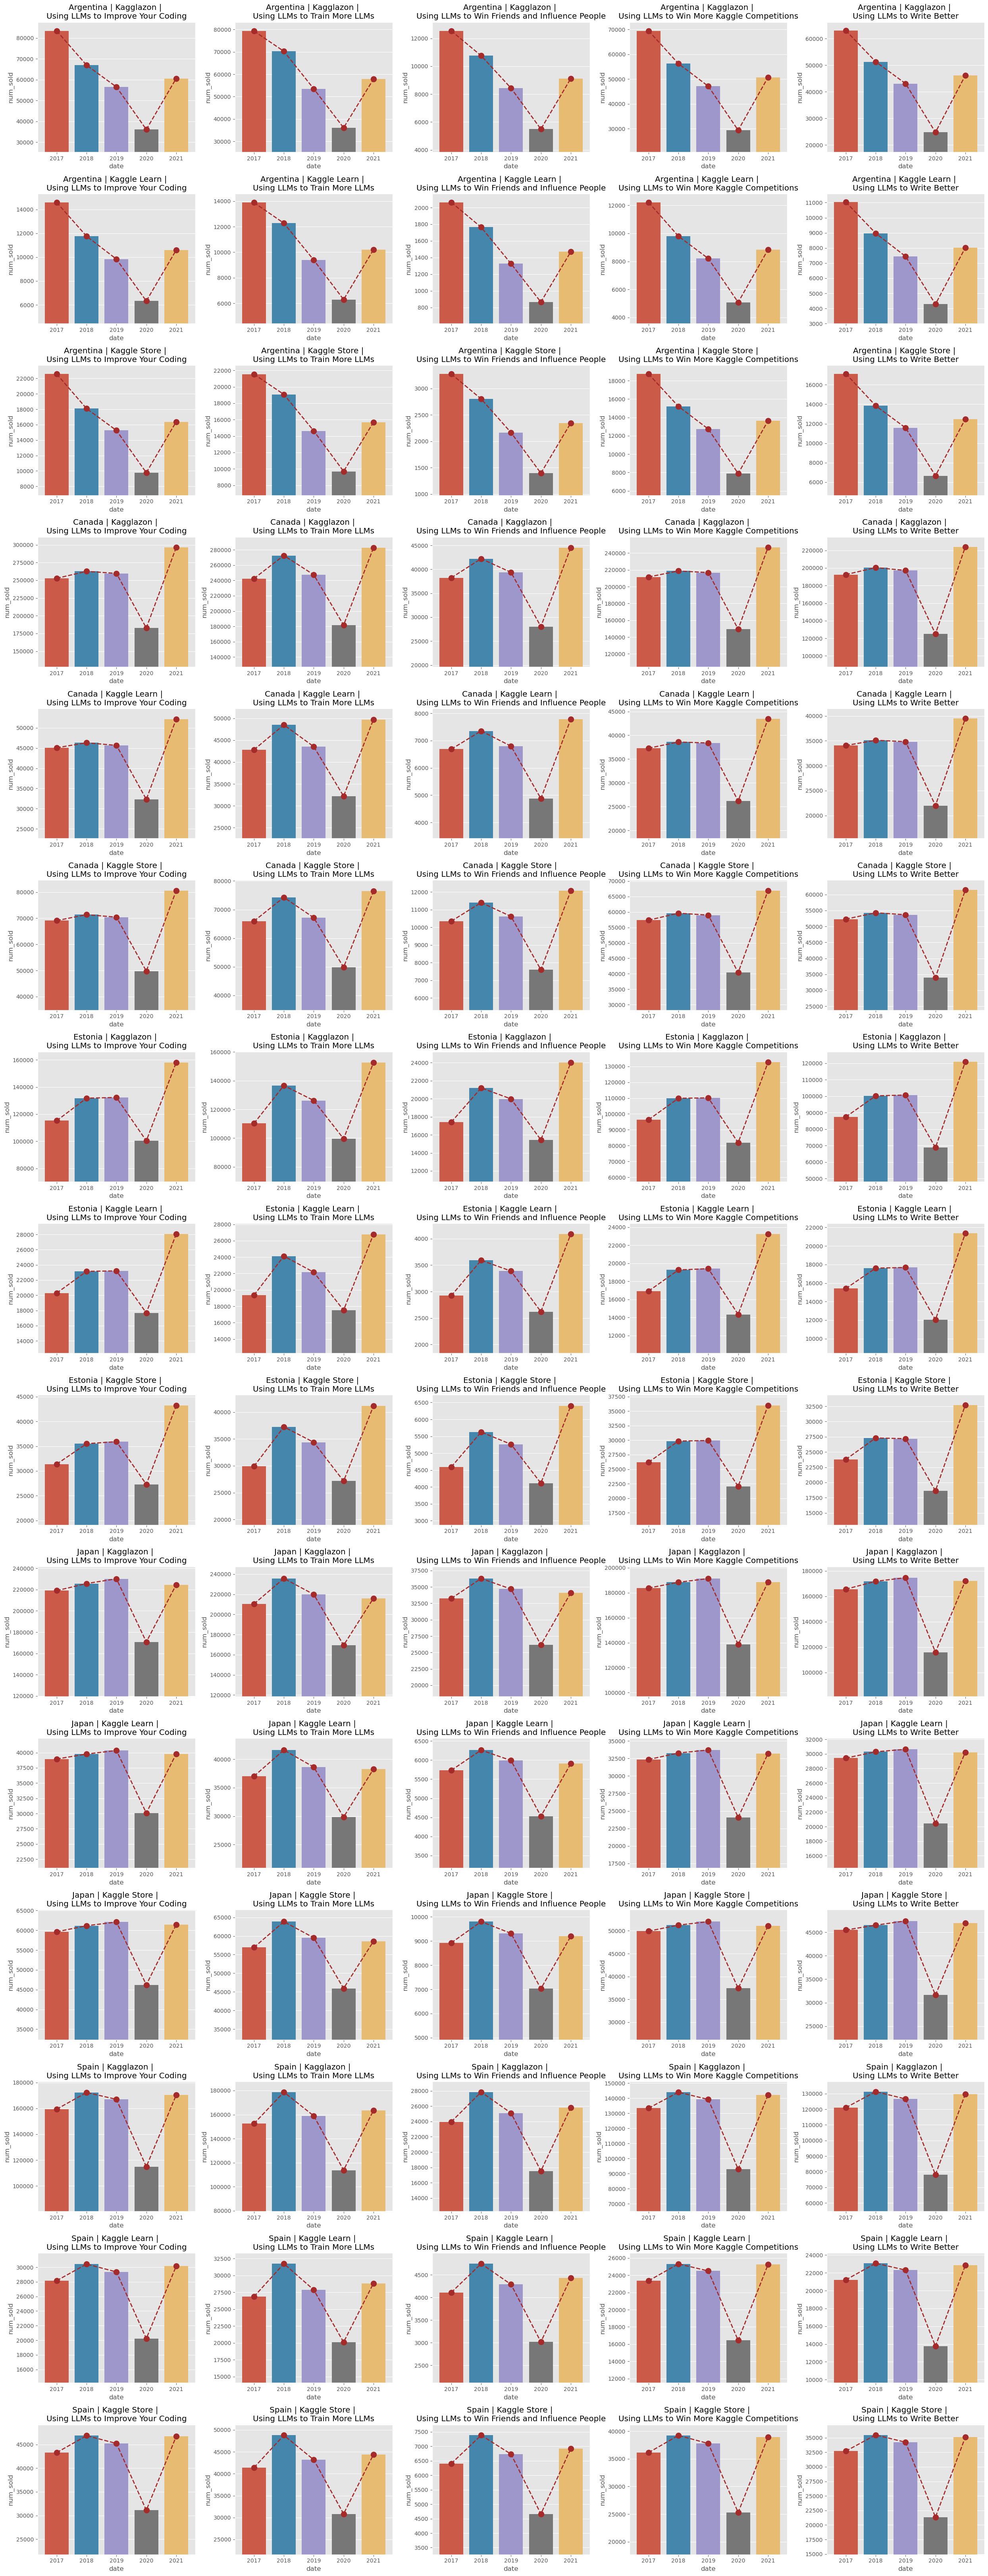

In [10]:
fig, ax = plt.subplots(15, 5, figsize = (25, 65))
ax = ax.flatten()
for i, (combination, df) in enumerate(train.groupby(['country', 'store', 'product'])):
    data = df.groupby(df.date.dt.year)['num_sold'].sum().reset_index()
    sns.barplot(data = data, x = 'date', y = 'num_sold', ax = ax[i])
    ax[i].plot(ax[i].get_xticks(), data.num_sold,
               color = 'brown', linestyle = '--', marker = '.',
               markersize = 20, linewidth = 2
    )
    lims = ax[i].get_ylim()
    ax[i].set_ylim(data.num_sold.min()*0.7, lims[1])
    ax[i].set_title(combination[0] + ' | ' + combination[1] +  ' | ' + '\n' + combination[2])
plt.tight_layout()

From the above, we can see in most countries there is a significant increase in `num_sold` from 2020 to 2021.

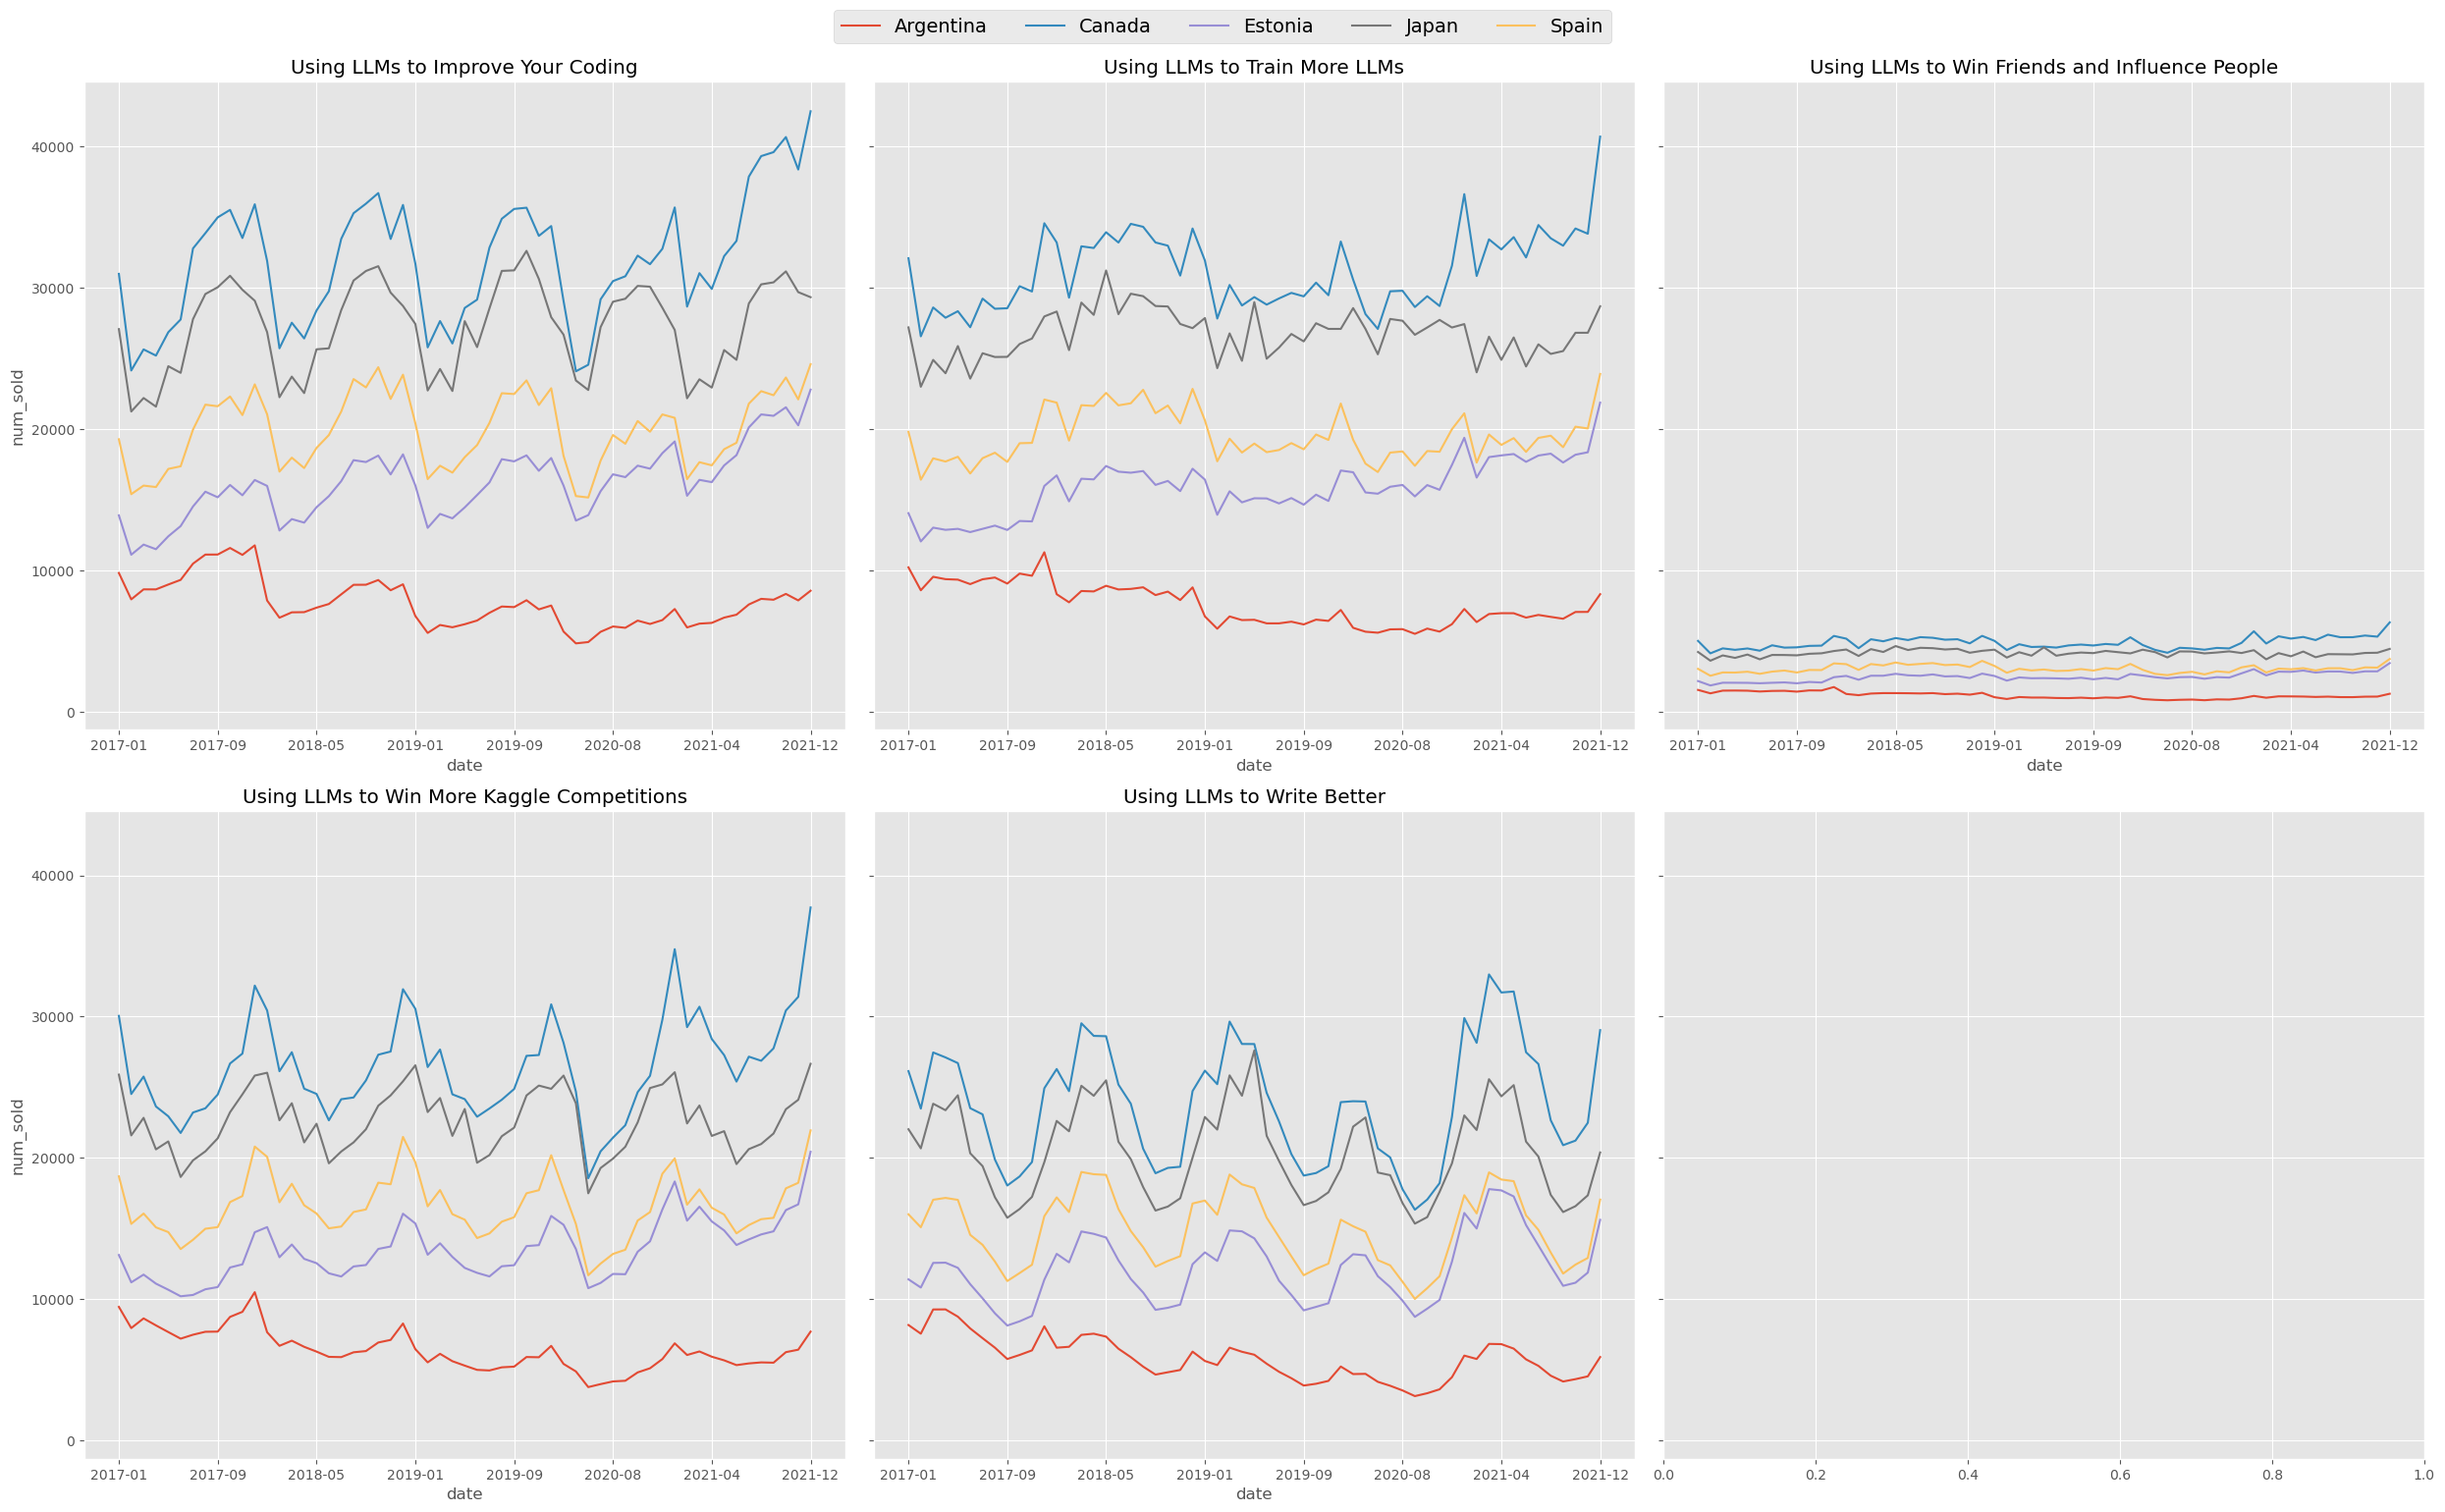

In [11]:
fig, ax = plt.subplots(2, 3, figsize = (25, 15), sharey = True)
ax = ax.flatten()
hue_order = train.country.unique()

for i, product in enumerate(train['product'].unique()):
    df = train[train['product'] == product]
    sns.lineplot(data = df.groupby([df.date.dt.strftime('%Y-%m'), df.country])['num_sold'].sum().reset_index(),
                 x = 'date',
                 y = 'num_sold',
                 hue = 'country',
                 ax = ax[i],
                 hue_order = hue_order
    )
    ax[i].set_title(product)
    ax[i].xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    
    handles = ax[i].get_legend_handles_labels()[0]
    labels = ax[i].get_legend_handles_labels()[1]
    ax[i].legend().remove()
    
fig.legend(handles, labels, loc = 'upper center', bbox_to_anchor=(0.5, 1.03), fontsize = 14, ncol = 6)
plt.tight_layout()

From the above, we see:

- The difference in `num_sold` across the countries is clear.
- It seems that there is a monthly seasonality in `num_sold`.

<a id="5"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 1.0</h1>


In [12]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

def get_holidays(df):
    years_list = [2017, 2018, 2019, 2020, 2021, 2022]

    holiday_AR = holidays.CountryHoliday('AR', years = years_list)
    holiday_CA = holidays.CountryHoliday('CA', years = years_list)
    holiday_ES = holidays.CountryHoliday('EE', years = years_list)
    holiday_JA = holidays.CountryHoliday('JP', years = years_list)
    holiday_SP = holidays.CountryHoliday('ES', years = years_list)

    holiday_dict = holiday_AR.copy()
    holiday_dict.update(holiday_CA)
    holiday_dict.update(holiday_ES)
    holiday_dict.update(holiday_JA)
    holiday_dict.update(holiday_SP)

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    df.drop(columns = 'holiday_name', axis = 1, inplace = True)
    
    return df


def feature_engineer(df):
    
    new_df = df.copy()
    new_df['month'] = df['date'].dt.month
    new_df['month_sin'] = np.sin(new_df['month'] * (2 * np.pi / 12))
    new_df['month_cos'] = np.cos(new_df['month'] * (2 * np.pi / 12))
    
    new_df['day'] = df['date'].dt.day
    new_df['day_sin'] = np.sin(new_df['day'] * (2 * np.pi / 365))
    new_df['day_cos'] = np.cos(new_df['day'] * (2 * np.pi / 365))
    
    new_df['day_of_week'] = df['date'].dt.dayofweek
    new_df['day_of_week'] = new_df['day_of_week'].apply(lambda x: 0 if x <= 3 else(1 if x == 4 else (2 if x == 5 else (3))))
    
    new_df = pd.get_dummies(new_df, columns = ['day_of_week'], drop_first = True)
    
    new_df['day_of_year'] = df['date'].dt.dayofyear
    new_df['day_of_year'] = new_df.apply(lambda x: x['day_of_year']-1 if (x['date'] > pd.Timestamp('2020-02-29') and x['date'] < pd.Timestamp('2021-01-01'))  else x['day_of_year'], axis = 1)
    new_df['year'] = df['date'].dt.year
    
    important_dates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 124, 125, 126, 127, 140, 141, 
                       167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 
                       203, 230, 231, 232, 233, 234, 282, 289, 290, 307, 308, 309, 310, 311, 
                       312, 313, 317, 318, 319, 320, 360, 361, 362, 363, 364, 365]
    
    new_df['important_date'] = np.where(np.isin(new_df['day'], important_dates), 1, 0)
    
    new_df = pd.get_dummies(new_df, columns = ['country'], drop_first = True)
    new_df = pd.get_dummies(new_df, columns = ['store'], drop_first = True)
    new_df = pd.get_dummies(new_df, columns = ['product'], drop_first = True)
    
    return new_df

train = get_holidays(train)
train = feature_engineer(train)

test = get_holidays(test)
test = feature_engineer(test)

In [13]:
X = train.drop(columns = ['id', 'date', 'num_sold'], axis = 1)
Y = train['num_sold']

test_baseline = test.drop(columns = ['id', 'date'], axis = 1)

linear_preds, linear_smape = list(), list()
ridge_preds, ridge_smape = list(), list()
lasso_preds, lasso_smape = list(), list()
elastic_preds, elastic_smape = list(), list()
avg_preds, avg_smape = list(), list()
lad_preds, lad_smape = list(), list()

kf = GroupKFold(n_splits = 5)

for i, (trn_idx, test_idx) in enumerate(kf.split(X, groups = X.year)):
    
    x_train, x_valid = X.iloc[trn_idx], X.iloc[test_idx]
    y_train, y_valid = Y.iloc[trn_idx], Y.iloc[test_idx]
    
    y_train = np.log(y_train)
    y_valid = np.log(y_valid)
    
    print('---------------------------------------------------------------')
    
    ##################
    ## Linear model ##
    ##################
    
    # linear_model = make_pipeline(StandardScaler(), LinearRegression()).fit(x_train, y_train)
    linear_model = LinearRegression().fit(x_train, y_train)

    linear_y_pred = np.exp(linear_model.predict(x_valid))
    linear_smape_oof = smape(np.exp(y_valid), linear_y_pred) 
    
    print('Fold', i, '==> Linear oof SMAPE is ==>', linear_smape_oof)

    linear_smape.append(linear_smape_oof)
    linear_pred = np.exp(linear_model.predict(test_baseline))
    linear_preds.append(linear_pred)
    
    ###########
    ## Ridge ##
    ###########
    
    # ridge_model = make_pipeline(StandardScaler(),
                                # Ridge(alpha = 0.0999, tol = 1e-2, max_iter = 1000000, random_state = 42)).fit(x_train, y_train)
    ridge_model = Ridge(alpha = 0.01, tol = 1e-2, max_iter = 1000000, random_state = 42).fit(x_train, y_train)

    ridge_y_pred = np.exp(ridge_model.predict(x_valid))
    ridge_smape_oof = smape(np.exp(y_valid), ridge_y_pred)
    
    print('Fold', i, '==> Ridge oof SMAPE is ==>', ridge_smape_oof)
    
    ridge_smape.append(ridge_smape_oof)
    ridge_pred = np.exp(ridge_model.predict(test_baseline))
    ridge_preds.append(ridge_pred)
    
    ###########
    ## Lasso ##
    ###########
    
    lasso_model = make_pipeline(StandardScaler(),
                                Lasso(alpha = 0.001, max_iter = 10000000, random_state = 42)).fit(x_train, y_train)
    # lasso_model = Lasso(alpha = 0.001, tol = 1e-2, max_iter = 1000000, random_state = 42).fit(x_train, y_train)

    lasso_y_pred = np.exp(lasso_model.predict(x_valid))
    lasso_smape_oof = smape(np.exp(y_valid), lasso_y_pred) 
    
    print('Fold', i, '==> Lasso oof SMAPE is ==>', lasso_smape_oof)
    
    lasso_smape.append(lasso_smape_oof)
    lasso_pred = np.exp(lasso_model.predict(test_baseline))
    lasso_preds.append(lasso_pred)
    
    #############
    ## Elastic ##
    #############
    
    # elastic_model = make_pipeline(StandardScaler(), 
    #                               ElasticNet(alpha = 0.0002, l1_ratio = 0.001, random_state = 42)).fit(x_train, y_train)
    elastic_model = ElasticNet(alpha = 0.0002, l1_ratio = 0.001, random_state = 42).fit(x_train, y_train)

    elastic_y_pred = np.exp(elastic_model.predict(x_valid))
    elastic_smape_oof = smape(np.exp(y_valid), elastic_y_pred) 
    
    print('Fold', i, '==> Elastic oof SMAPE is ==>', elastic_smape_oof)
    
    elastic_smape.append(elastic_smape_oof)
    elastic_pred = np.exp(elastic_model.predict(test_baseline))
    elastic_preds.append(elastic_pred)
    
    ######################
    ## Average Ensemble ##
    ######################
    
    ens_pred_1 = (linear_y_pred + ridge_y_pred + lasso_y_pred + elastic_y_pred) / 4
    ens_pred_2 = (linear_pred + ridge_pred + lasso_pred + elastic_pred) / 4
    
    avg_smape_oof = smape(np.exp(y_valid), ens_pred_1)
    
    print('Fold', i, '==> Average Ensemble oof SMAPE is ==>', avg_smape_oof)
    
    avg_smape.append(avg_smape_oof)
    avg_preds.append(ens_pred_2)
    
    ##################
    ## LAD Ensemble ##
    ##################
    
    x = pd.DataFrame({'LR': linear_y_pred,
                      'Ridge': ridge_y_pred,
                      'Lasso': lasso_y_pred,
                      'Elastic': elastic_y_pred})
    
    y = np.exp(y_valid).copy()
        
    x_test = pd.DataFrame({'LR': linear_pred,
                           'Ridge': ridge_pred,
                           'Lasso': lasso_pred,
                           'Elastic': elastic_pred})
    
    lad_md = LADRegression().fit(x, y)
    lad_pred = lad_md.predict(x)
    lad_pred_test = lad_md.predict(x_test)
    
    lad_smape_oof = smape(y, lad_pred)
    
    print('Fold', i, '==> LAD Ensemble SMAPE is ==>', lad_smape_oof)
    
    lad_smape.append(lad_smape_oof)
    lad_preds.append(lad_pred_test)

---------------------------------------------------------------
Fold 0 ==> Linear oof SMAPE is ==> 17.96530604098144
Fold 0 ==> Ridge oof SMAPE is ==> 17.963762199291665
Fold 0 ==> Lasso oof SMAPE is ==> 17.96189267143978
Fold 0 ==> Elastic oof SMAPE is ==> 18.04901878341154
Fold 0 ==> Average Ensemble oof SMAPE is ==> 17.979711894012254
Fold 0 ==> LAD Ensemble SMAPE is ==> 12.061877792863193
---------------------------------------------------------------
Fold 1 ==> Linear oof SMAPE is ==> 11.020294718661464
Fold 1 ==> Ridge oof SMAPE is ==> 11.018776410770993
Fold 1 ==> Lasso oof SMAPE is ==> 11.090182905818853
Fold 1 ==> Elastic oof SMAPE is ==> 11.066851063163597
Fold 1 ==> Average Ensemble oof SMAPE is ==> 11.04044016756501
Fold 1 ==> LAD Ensemble SMAPE is ==> 10.40979163040835
---------------------------------------------------------------
Fold 2 ==> Linear oof SMAPE is ==> 11.878648823311053
Fold 2 ==> Ridge oof SMAPE is ==> 11.87838947536428
Fold 2 ==> Lasso oof SMAPE is ==> 11.

We next proceed to compare model performance.

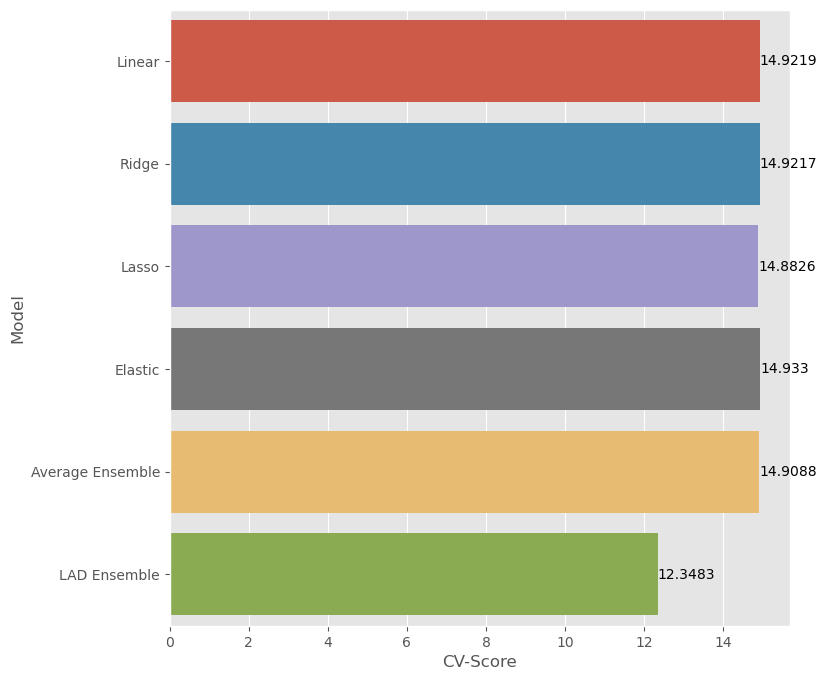

In [14]:
linear_cv_score = np.mean(linear_smape)
ridge_cv_score = np.mean(ridge_smape)
lasso_cv_score = np.mean(lasso_smape)
elastic_cv_score = np.mean(elastic_smape)
avg_cv_score = np.mean(avg_smape)
lad_cv_score = np.mean(lad_smape)

md_perf = pd.DataFrame({'Model': ['Linear', 'Ridge', 'Lasso', 'Elastic', 'Average Ensemble', 'LAD Ensemble'], 
                        'CV-Score': [linear_cv_score, ridge_cv_score, lasso_cv_score, elastic_cv_score, avg_cv_score, lad_cv_score]})

plt.figure(figsize = (8, 8))
ax = sns.barplot(y = 'Model', x = 'CV-Score', data = md_perf)
ax.bar_label(ax.containers[0]);

In [15]:
lad_preds_test = pd.DataFrame(lad_preds).apply(np.mean, axis = 0)

submission['num_sold'] = round(lad_preds_test).astype(int)
submission.head()

id  num_sold
0  136950        32
1  136951        32
2  136952         5
3  136953        27
4  136954        24

In [16]:
submission.to_csv('LAD_Ensemble_Baseline_submission_1.csv', index = False)

<a id="5"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 2.0</h1>

In [17]:
train = pd.read_csv('../input/playground-series-s3e19/train.csv')
train['date'] = pd.to_datetime(train['date'])

## Removing covid dates
train = train.loc[~((train['date'] >= '2020-03-01') & (train['date'] < '2020-06-01'))]

test = pd.read_csv('../input/playground-series-s3e19/test.csv')
test['date'] = pd.to_datetime(test['date'])

submission = pd.read_csv('../input/playground-series-s3e19/sample_submission.csv')
submission.columns = ['id', 'num_sold']

In [18]:
train['product'] = train['product'].str.replace(' ', '_')
test['product'] = test['product'].str.replace(' ', '_')


def get_holidays(df):
    years_list = [2017, 2018, 2019, 2020, 2021, 2022]

    holiday_AR = holidays.CountryHoliday('AR', years = years_list)
    holiday_CA = holidays.CountryHoliday('CA', years = years_list)
    holiday_ES = holidays.CountryHoliday('EE', years = years_list)
    holiday_JA = holidays.CountryHoliday('JP', years = years_list)
    holiday_SP = holidays.CountryHoliday('ES', years = years_list)

    holiday_dict = holiday_AR.copy()
    holiday_dict.update(holiday_CA)
    holiday_dict.update(holiday_ES)
    holiday_dict.update(holiday_JA)
    holiday_dict.update(holiday_SP)

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    df.drop(columns = 'holiday_name', axis = 1, inplace = True)
    
    return df


def feature_engineer(df):
    
    new_df = df.copy()
    new_df['month'] = df['date'].dt.month
    new_df['month_sin'] = np.sin(new_df['month'] * (2 * np.pi / 12))
    new_df['month_cos'] = np.cos(new_df['month'] * (2 * np.pi / 12))
    
    new_df['day'] = df['date'].dt.day
    new_df['day_sin'] = np.sin(new_df['day'] * (2 * np.pi / 365))
    new_df['day_cos'] = np.cos(new_df['day'] * (2 * np.pi / 365))
    
    new_df['day_of_week'] = df['date'].dt.dayofweek
    new_df['day_of_week'] = new_df['day_of_week'].apply(lambda x: 0 if x <= 3 else(1 if x == 4 else (2 if x == 5 else (3))))
    
    new_df = pd.get_dummies(new_df, columns = ['day_of_week'], drop_first = True)
    
    new_df['day_of_year'] = df['date'].dt.dayofyear
    new_df['day_of_year'] = new_df.apply(lambda x: x['day_of_year']-1 if (x['date'] > pd.Timestamp('2020-02-29') and x['date'] < pd.Timestamp('2021-01-01'))  else x['day_of_year'], axis = 1)
    new_df['year'] = df['date'].dt.year
    
    important_dates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 124, 125, 126, 127, 140, 141, 
                       167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 
                       203, 230, 231, 232, 233, 234, 282, 289, 290, 307, 308, 309, 310, 311, 
                       312, 313, 317, 318, 319, 320, 360, 361, 362, 363, 364, 365]
    
    new_df['important_date'] = np.where(np.isin(new_df['day'], important_dates), 1, 0)
    
#     new_df = pd.get_dummies(new_df, columns = ['country'], drop_first = True)
#     new_df = pd.get_dummies(new_df, columns = ['store'], drop_first = True)
#     new_df = pd.get_dummies(new_df, columns = ['product'], drop_first = True)
    
    return new_df

First, we aggregate sales at the country level. 

In [19]:
train_md = train.groupby(['country', 'date'])['num_sold'].sum().reset_index()
train_md['year'] = train_md['date'].dt.year

test_md = test.groupby(['country', 'date'])['id'].first().reset_index().drop(columns = 'id')
test_md['year'] = test_md['date'].dt.year

Next, we create a data-frame witht the countries historical GDP (make sure the GDPs are on the same scale). Argentina and Estonia are billions, the other countries are in trillions.

In [20]:
country_gdp = pd.DataFrame({'country': np.repeat(['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain'], 6).tolist(),
                           'year': [2017, 2018, 2019, 2020, 2021, 2022] * 5, 
                           'gdp': [643.63, 524.82, 447.75, 385.54, 487.23, 632.77,
                                   1.65*np.power(10, 3), 1.73*np.power(10, 3), 1.74*np.power(10, 3), 1.65*np.power(10, 3), 2*np.power(10, 3), 2.14*np.power(10, 3),
                                   26.92, 30.62, 31.08, 31.37, 37.19, 38.1,
                                   4.93*np.power(10, 3), 5.04*np.power(10, 3), 5.12*np.power(10, 3), 5.05*np.power(10, 3), 5.01*np.power(10, 3), 4.23*np.power(10, 3),
                                   1.31*np.power(10, 3), 1.42*np.power(10, 3), 1.39*np.power(10, 3), 1.28*np.power(10, 3), 1.43*np.power(10, 3), 1.4*np.power(10, 3)]
                           })
country_gdp['gdp'] = np.log(country_gdp['gdp'])
country_gdp.head()

country  year       gdp
0  Argentina  2017  6.467124
1  Argentina  2018  6.263055
2  Argentina  2019  6.104235
3  Argentina  2020  5.954645
4  Argentina  2021  6.188736

Next we append GDP data to `train` and `test` datasets.

In [21]:
train_md = pd.merge(train_md, country_gdp, on = ['year', 'country'])
train_md = train_md.drop(columns = ['country', 'year'], axis = 1)
print('-------------------')
print('-- Train Dataset --')
print('-------------------')
print(train_md.head())

test_md = pd.merge(test_md, country_gdp, on = ['year', 'country'])
test_md = test_md.drop(columns = ['country', 'year'], axis = 1)
print('-------------------')
print('-- Test Dataset --')
print('-------------------')
print(test_md.head())

-------------------
-- Train Dataset --
-------------------
        date  num_sold       gdp
0 2017-01-01      2011  6.467124
1 2017-01-02      1487  6.467124
2 2017-01-03      1448  6.467124
3 2017-01-04      1357  6.467124
4 2017-01-05      1316  6.467124
-------------------
-- Test Dataset --
-------------------
        date       gdp
0 2022-01-01  6.450107
1 2022-01-02  6.450107
2 2022-01-03  6.450107
3 2022-01-04  6.450107
4 2022-01-05  6.450107


Finally, we append engineered features based on dates.

In [22]:
train_md = get_holidays(train_md)
train_md = feature_engineer(train_md)
print('-------------------')
print('-- Train Dataset --')
print('-------------------')
print(train_md.head())

test_md = get_holidays(test_md)
test_md = feature_engineer(test_md)
print('------------------')
print('-- Test Dataset --')
print('------------------')
print(train_md.head())

-------------------
-- Train Dataset --
-------------------
        date  num_sold       gdp  is_holiday  month  month_sin  month_cos  \
0 2017-01-01      2011  6.467124           1      1        0.5   0.866025   
1 2017-01-02      1487  6.467124           1      1        0.5   0.866025   
2 2017-01-03      1448  6.467124           0      1        0.5   0.866025   
3 2017-01-04      1357  6.467124           0      1        0.5   0.866025   
4 2017-01-05      1316  6.467124           0      1        0.5   0.866025   

   day   day_sin   day_cos  day_of_week_1  day_of_week_2  day_of_week_3  \
0    1  0.017213  0.999852              0              0              1   
1    2  0.034422  0.999407              0              0              0   
2    3  0.051620  0.998667              0              0              0   
3    4  0.068802  0.997630              0              0              0   
4    5  0.085965  0.996298              0              0              0   

   day_of_year  year  impo

In [23]:
X = train_md.drop(columns = ['date', 'num_sold'], axis = 1)
Y = train_md['num_sold']

test_baseline = test_md.drop(columns = ['date', 'year'], axis = 1)

linear_preds, linear_smape = list(), list()
ridge_preds, ridge_smape = list(), list()
lasso_preds, lasso_smape = list(), list()
elastic_preds, elastic_smape = list(), list()
avg_preds, avg_smape = list(), list()
lad_preds, lad_smape = list(), list()

kf = GroupKFold(n_splits = 5)

for i, (trn_idx, test_idx) in enumerate(kf.split(X, groups = X.year)):
    
    x_train, x_valid = X.iloc[trn_idx], X.iloc[test_idx]
    y_train, y_valid = Y.iloc[trn_idx], Y.iloc[test_idx]
    
    x_train = x_train.drop(columns = 'year', axis = 1)
    x_valid = x_valid.drop(columns = 'year', axis = 1)
    
    y_train = np.log(y_train)
    y_valid = np.log(y_valid)
    
    print('---------------------------------------------------------------')
    
    ##################
    ## Linear model ##
    ##################
    
    linear_model = LinearRegression().fit(x_train, y_train)

    linear_y_pred = np.exp(linear_model.predict(x_valid))
    linear_smape_oof = smape(np.exp(y_valid), linear_y_pred)
    
    print('Fold', i, '==> Linear oof SMAPE is ==>', linear_smape_oof)

    linear_smape.append(linear_smape_oof)
    linear_pred = np.exp(linear_model.predict(test_baseline))
    linear_preds.append(linear_pred)
    
    ###########
    ## Ridge ##
    ###########
    
    ridge_model = Ridge(alpha = 0.01, tol = 1e-2, max_iter = 1000000, random_state = 42).fit(x_train, y_train)

    ridge_y_pred = np.exp(ridge_model.predict(x_valid))
    ridge_smape_oof = smape(np.exp(y_valid), ridge_y_pred)
    
    print('Fold', i, '==> Ridge oof SMAPE is ==>', ridge_smape_oof)
    
    ridge_smape.append(ridge_smape_oof)
    ridge_pred = np.exp(ridge_model.predict(test_baseline))
    ridge_preds.append(ridge_pred)
    
    ###########
    ## Lasso ##
    ###########
    
    lasso_model = make_pipeline(StandardScaler(),
                                Lasso(alpha = 0.001, max_iter = 10000000, random_state = 42)).fit(x_train, y_train)

    lasso_y_pred = np.exp(lasso_model.predict(x_valid))
    lasso_smape_oof = smape(np.exp(y_valid), lasso_y_pred)
    
    print('Fold', i, '==> Lasso oof SMAPE is ==>', lasso_smape_oof)
    
    lasso_smape.append(lasso_smape_oof)
    lasso_pred = np.exp(lasso_model.predict(test_baseline))
    lasso_preds.append(lasso_pred)
    
    #############
    ## Elastic ##
    #############
    
    elastic_model = ElasticNet(alpha = 0.0002, l1_ratio = 0.001, random_state = 42).fit(x_train, y_train)

    elastic_y_pred = np.exp(elastic_model.predict(x_valid))
    elastic_smape_oof = smape(np.exp(y_valid), elastic_y_pred)
    
    print('Fold', i, '==> Elastic oof SMAPE is ==>', elastic_smape_oof)
    
    elastic_smape.append(elastic_smape_oof)
    elastic_pred = np.exp(elastic_model.predict(test_baseline))
    elastic_preds.append(elastic_pred)
    
    ######################
    ## Average Ensemble ##
    ######################
    
    ens_pred_1 = (linear_y_pred + ridge_y_pred + lasso_y_pred + elastic_y_pred) / 4
    ens_pred_2 = (linear_pred + ridge_pred + lasso_pred + elastic_pred) / 4
    
    avg_smape_oof = smape(np.exp(y_valid), ens_pred_1)
    
    print('Fold', i, '==> Average Ensemble oof SMAPE is ==>', avg_smape_oof)
    
    avg_smape.append(avg_smape_oof)
    avg_preds.append(ens_pred_2)
    
    ##################
    ## LAD Ensemble ##
    ##################
    
    x = pd.DataFrame({'LR': linear_y_pred,
                      'Ridge': ridge_y_pred,
                      'Lasso': lasso_y_pred,
                      'Elastic': elastic_y_pred})
    
    y = np.exp(y_valid).copy()
        
    x_test = pd.DataFrame({'LR': linear_pred,
                           'Ridge': ridge_pred,
                           'Lasso': lasso_pred,
                           'Elastic': elastic_pred})
    
    lad_md = LADRegression().fit(x, y)
    lad_pred = lad_md.predict(x)
    lad_pred_test = lad_md.predict(x_test)
    
    lad_smape_oof = smape(y, lad_pred)
    
    print('Fold', i, '==> LAD Ensemble SMAPE is ==>', lad_smape_oof)
    
    lad_smape.append(lad_smape_oof)
    lad_preds.append(lad_pred_test)

---------------------------------------------------------------
Fold 0 ==> Linear oof SMAPE is ==> 38.9591196687862
Fold 0 ==> Ridge oof SMAPE is ==> 38.95844788500706
Fold 0 ==> Lasso oof SMAPE is ==> 38.964249090265454
Fold 0 ==> Elastic oof SMAPE is ==> 38.950447710237626
Fold 0 ==> Average Ensemble oof SMAPE is ==> 38.951507464319896
Fold 0 ==> LAD Ensemble SMAPE is ==> 32.29272038136283
---------------------------------------------------------------
Fold 1 ==> Linear oof SMAPE is ==> 34.372458545621626
Fold 1 ==> Ridge oof SMAPE is ==> 34.376812735255704
Fold 1 ==> Lasso oof SMAPE is ==> 34.36736034029627
Fold 1 ==> Elastic oof SMAPE is ==> 34.37464172341097
Fold 1 ==> Average Ensemble oof SMAPE is ==> 34.36841135218992
Fold 1 ==> LAD Ensemble SMAPE is ==> 30.240988259005245
---------------------------------------------------------------
Fold 2 ==> Linear oof SMAPE is ==> 34.00263090883582
Fold 2 ==> Ridge oof SMAPE is ==> 34.001287592652076
Fold 2 ==> Lasso oof SMAPE is ==> 34.01

Next, we compare the models performance.

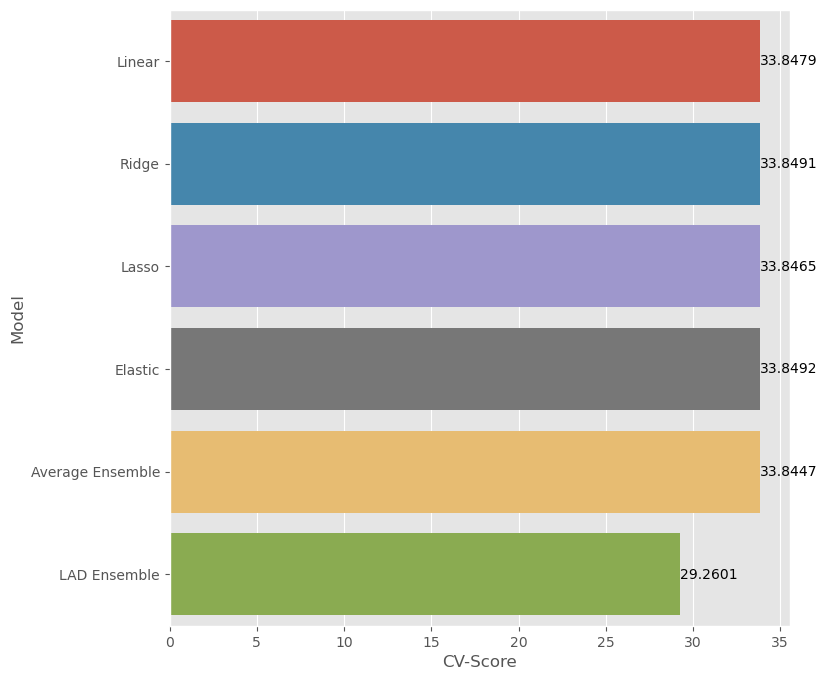

In [24]:
linear_cv_score = np.mean(linear_smape)
ridge_cv_score = np.mean(ridge_smape)
lasso_cv_score = np.mean(lasso_smape)
elastic_cv_score = np.mean(elastic_smape)
avg_cv_score = np.mean(avg_smape)
lad_cv_score = np.mean(lad_smape)

md_perf = pd.DataFrame({'Model': ['Linear', 'Ridge', 'Lasso', 'Elastic', 'Average Ensemble', 'LAD Ensemble'], 
                        'CV-Score': [linear_cv_score, ridge_cv_score, lasso_cv_score, elastic_cv_score, avg_cv_score, lad_cv_score]})

plt.figure(figsize = (8, 8))
ax = sns.barplot(y = 'Model', x = 'CV-Score', data = md_perf)
ax.bar_label(ax.containers[0]);

In [25]:
lad_preds_test = pd.DataFrame(lad_preds).apply(np.mean, axis = 0)
test_preds = pd.DataFrame({'date': test_md['date'], 'num_sold': lad_preds_test})
test_preds['country'] = np.repeat(['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain'], 365).tolist()
test_preds.head()

date     num_sold    country
0 2022-01-01  2741.022578  Argentina
1 2022-01-02  2884.243126  Argentina
2 2022-01-03  2521.653774  Argentina
3 2022-01-04  2496.047409  Argentina
4 2022-01-05  2495.977360  Argentina

Finally, we desaggregate the data by store and product at country level.

In [26]:
def country_store_ratio(df, country):
    
    country_store_ratio = df[df['country'] == country].groupby(['date', 'store'])['num_sold'].sum().reset_index()
    country_store_ratio = country_store_ratio.pivot(index = 'date', columns = 'store', values = 'num_sold')
    country_store_ratio = country_store_ratio.apply(lambda x: x / x.sum(), axis = 1)
    country_store_ratio = country_store_ratio.stack().rename('ratios').reset_index()
    country_store_ratio = country_store_ratio[((country_store_ratio['date'] <= '12-31-2019') | (country_store_ratio['date'] >= '01-01-2021'))].reset_index(drop = True) 
    country_store_ratio['mm-dd'] = country_store_ratio['date'].dt.strftime('%m-%d')
    country_store_ratio = country_store_ratio.groupby(['store', 'mm-dd'])['ratios'].mean().reset_index()
    country_store_ratio.columns = ['store', 'mm-dd', 'store_ratio']
    
    return country_store_ratio


def country_product_ratio(df, country):
    
    country_product_ratio = df[df['country'] == country].groupby(['date', 'product'])['num_sold'].sum().reset_index()
    country_product_ratio = country_product_ratio.pivot(index = 'date', columns = 'product', values = 'num_sold')
    country_product_ratio = country_product_ratio.apply(lambda x: x / x.sum(), axis = 1)
    country_product_ratio = country_product_ratio.stack().rename('ratios').reset_index()
    country_product_ratio = country_product_ratio[((country_product_ratio['date'] <= '12-31-2019') | (country_product_ratio['date'] >= '01-01-2021'))].reset_index(drop = True) 
    country_product_ratio['mm-dd'] = country_product_ratio['date'].dt.strftime('%m-%d')
    country_product_ratio = country_product_ratio.groupby(['product', 'mm-dd'])['ratios'].mean().reset_index()
    country_product_ratio.columns = ['product', 'mm-dd', 'product_ratio']
    
    return country_product_ratio
    

def ratios(test_df, train_df):
    
    results = list()
    
    for i in ['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain']:
        
        data_temp_1 = country_store_ratio(train_df, i)
        data_temp_2 = country_product_ratio(train_df, i)
        data_temp_3 = test_df[test_df['country'] == i].reset_index(drop = True)
        
        data_out = pd.merge(data_temp_3, data_temp_1, on = ['store', 'mm-dd'], how = 'left')
        data_out = pd.merge(data_out, data_temp_2, on = ['product', 'mm-dd'], how = 'left')
        
        results.append(data_out)
        
    return results

In [27]:
test = pd.merge(test, test_preds, on = ['date', 'country'], how = 'left')
test['mm-dd'] = test['date'].dt.strftime('%m-%d')
test.head()

id       date    country         store  \
0  136950 2022-01-01  Argentina  Kaggle Learn   
1  136951 2022-01-01  Argentina  Kaggle Learn   
2  136952 2022-01-01  Argentina  Kaggle Learn   
3  136953 2022-01-01  Argentina  Kaggle Learn   
4  136954 2022-01-01  Argentina  Kaggle Learn   

                                          product     num_sold  mm-dd  
0               Using_LLMs_to_Improve_Your_Coding  2741.022578  01-01  
1                   Using_LLMs_to_Train_More_LLMs  2741.022578  01-01  
2  Using_LLMs_to_Win_Friends_and_Influence_People  2741.022578  01-01  
3      Using_LLMs_to_Win_More_Kaggle_Competitions  2741.022578  01-01  
4                      Using_LLMs_to_Write_Better  2741.022578  01-01

In [28]:
data_out = pd.concat(ratios(test, train))
data_out['num_sold_new'] = data_out['num_sold'] * data_out['store_ratio'] * data_out['product_ratio']
data_out.head()

id       date    country         store  \
0  136950 2022-01-01  Argentina  Kaggle Learn   
1  136951 2022-01-01  Argentina  Kaggle Learn   
2  136952 2022-01-01  Argentina  Kaggle Learn   
3  136953 2022-01-01  Argentina  Kaggle Learn   
4  136954 2022-01-01  Argentina  Kaggle Learn   

                                          product     num_sold  mm-dd  \
0               Using_LLMs_to_Improve_Your_Coding  2741.022578  01-01   
1                   Using_LLMs_to_Train_More_LLMs  2741.022578  01-01   
2  Using_LLMs_to_Win_Friends_and_Influence_People  2741.022578  01-01   
3      Using_LLMs_to_Win_More_Kaggle_Competitions  2741.022578  01-01   
4                      Using_LLMs_to_Write_Better  2741.022578  01-01   

   store_ratio  product_ratio  num_sold_new  
0     0.122286       0.259056     86.832453  
1     0.122286       0.254105     85.172791  
2     0.122286       0.038682     12.965699  
3     0.122286       0.247877     83.085147  
4     0.122286       0.200280     67.131391

In [29]:
data_out = data_out[['id', 'num_sold_new']].copy()
data_out.columns = ['id', 'num_sold']
data_out['num_sold'] = round(1.2*data_out['num_sold']) # magic number
data_out.head()

id  num_sold
0  136950     104.0
1  136951     102.0
2  136952      16.0
3  136953     100.0
4  136954      81.0

In [30]:
data_out.to_csv('LAD_Ensemble_Baseline_submission_2.csv', index = False)